In [54]:
%%capture

!pip install xgboost

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

In [2]:
data = pd.read_csv('Gemini_BTCEUR_d.csv', skiprows=1)
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume EUR
0,1703894400000,2023-12-30 00:00:00,BTC/EUR,38373.87,38642.87,37799.18,38344.54,1.281840,49151.567071
1,1703808000000,2023-12-29 00:00:00,BTC/EUR,38580.51,39850.30,37927.98,38373.87,2.185577,83869.047289
2,1703721600000,2023-12-28 00:00:00,BTC/EUR,39102.04,39434.93,38298.25,38580.51,1.734013,66899.088140
3,1703635200000,2023-12-27 00:00:00,BTC/EUR,38528.36,39171.43,38461.94,39102.04,2.171586,84913.435988
4,1703548800000,2023-12-26 00:00:00,BTC/EUR,39851.14,39851.14,38003.87,38528.36,0.423877,16331.277175


# Data Analysis

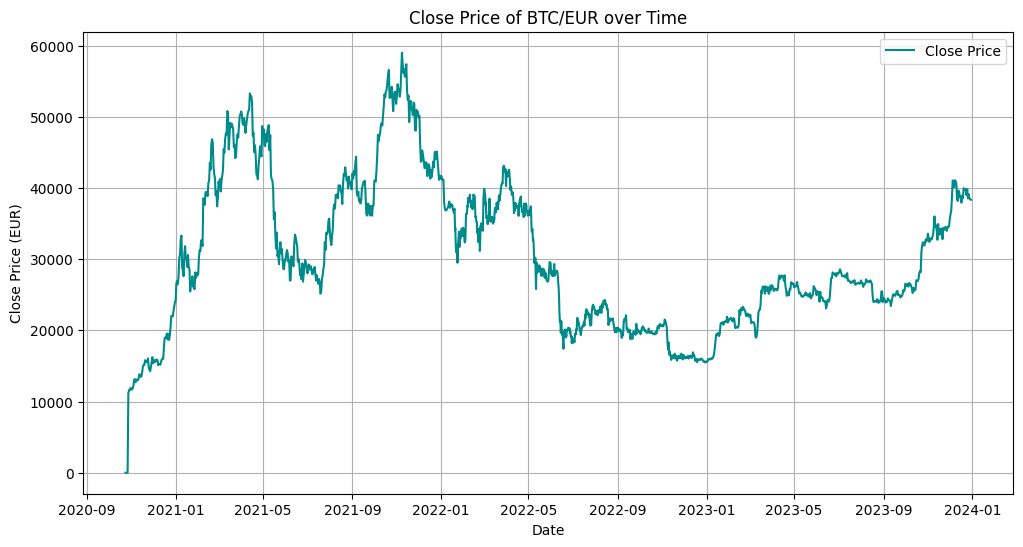

In [3]:
data['date'] = pd.to_datetime(data['date'])

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['close'], label='Close Price', color='darkcyan')
plt.title('Close Price of BTC/EUR over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (EUR)')
plt.legend()
plt.grid(True)
plt.show()

1. Stationarity:
 - Definition: A stationary time series is one whose properties do not depend on the time at which the series is observed.15 Thus, time series with trends, or with seasonality, are not stationary
 - Observation: Close Price does not showcase stationary since there's a clear upward trend

1. Trend:
 - Definition: The trend in a time series refers to the long-term increase or decrease in the data. It represents the underlying progression of the data over time, which could be upward, downward, or neutral
 - Observation: We see a clear upward trend in the year 2023, especially in the later months

1. Seasonality:
 - Definition: Seasonality refers to patterns or cycles that repeat over regular intervals within a time series data. These patterns are often driven by external factors and can occur due to seasonal factors (like quarters, months, days of the week, etc.), business cycles, or other cyclical patterns.
 - Observation: Our dataset does not showcase any consistent seasonality

> Our dataset is not stationary as it is common for financial time series.

**Is Stationarity a Useful Characteristic**?
Stationarity is important for predicting future trends because it means the data behaves consistently over time. If data is stationary, it's easier to make accurate forecasts because the patterns you see are likely to continue.

When data is not stationary and keeps changing, predicting what will happen next becomes more difficult, because what happened in the past may not be a reliable indicator of the future.

# Data Preprocessing

## Additional Features

**Lag Features**: Values from previous day(s). We will add the colsing dat from 1 and 7 days ago

In [4]:
data['lag_1'] = data['close'].shift(1)
data['lag_7'] = data['close'].shift(7)

**Day of the week**: Time series can exhibit different behaviors on different days of the week. Adding a day-of-the-week feature can capture weekly seasonality.

In [5]:
data['day_of_week'] = data['date'].dt.dayofweek

**Rolling Window Statistics**: These include rolling means and rolling standard deviations calculated over a window of past observations.

In [6]:
data['rolling_mean_7'] = data['close'].rolling(window=7).mean()
data['rolling_std_7'] = data['close'].rolling(window=7).std()

**Percentage Change**: Percent difference in price from one day to the next.

In [7]:
data['pct_change'] = data['close'].pct_change()

**Volume Changes**: The day-to-day percentage change in volume for both BTC and EUR.

In [8]:
data['volume_btc_change'] = data['Volume BTC'].pct_change()
data['volume_eur_change'] = data['Volume EUR'].pct_change()

In [9]:
data.head(10)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume EUR,lag_1,lag_7,day_of_week,rolling_mean_7,rolling_std_7,pct_change,volume_btc_change,volume_eur_change
0,1703894400000,2023-12-30,BTC/EUR,38373.87,38642.87,37799.18,38344.54,1.281840,49151.567071,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
1,1703808000000,2023-12-29,BTC/EUR,38580.51,39850.30,37927.98,38373.87,2.185577,83869.047289,38344.54,NaN,4,NaN,NaN,0.000765,0.705031,0.706335
2,1703721600000,2023-12-28,BTC/EUR,39102.04,39434.93,38298.25,38580.51,1.734013,66899.088140,38373.87,NaN,3,NaN,NaN,0.005385,-0.206611,-0.202339
3,1703635200000,2023-12-27,BTC/EUR,38528.36,39171.43,38461.94,39102.04,2.171586,84913.435988,38580.51,NaN,2,NaN,NaN,0.013518,0.252347,0.269276
4,1703548800000,2023-12-26,BTC/EUR,39851.14,39851.14,38003.87,38528.36,0.423877,16331.277175,39102.04,NaN,1,NaN,NaN,-0.014671,-0.804808,-0.807671
5,1703462400000,2023-12-25,BTC/EUR,39000.00,40690.19,39000.00,39851.14,0.141546,5640.778628,38528.36,NaN,0,NaN,NaN,0.034333,-0.666068,-0.654603
6,1703376000000,2023-12-24,BTC/EUR,39776.31,40690.14,39000.00,39000.00,1.011586,39451.842690,39851.14,NaN,6,38825.780000,538.897940,-0.021358,6.146681,5.994042
7,1703289600000,2023-12-23,BTC/EUR,39736.76,39977.74,39376.69,39776.31,0.184050,7320.833038,39000.00,38344.54,5,39030.318571,594.632813,0.019905,-0.818058,-0.814436
8,1703203200000,2023-12-22,BTC/EUR,39894.46,40296.61,39414.51,39736.76,1.720089,68350.764964,39776.31,38373.87,4,39225.017143,566.320157,-0.000994,8.345766,8.336474
9,1703116800000,2023-12-21,BTC/EUR,39949.14,40284.88,39529.99,39894.46,2.368190,94477.679978,39736.76,38580.51,3,39412.724286,533.922217,0.003969,0.376784,0.382248


In [10]:
data = data.drop(columns=['unix', 'date', 'Volume EUR'])

**Normalization**

For financial time series like OHLCV, Log Returns are often the most relevant normalization technique

In [11]:
data['open'] = np.log(data['open'].shift(-1) / data['open'])
data['high'] = np.log(data['high'].shift(-1) / data['high'])
data['low'] = np.log(data['low'].shift(-1) / data['low'])
data['close'] = np.log(data['close'].shift(-1) / data['close'])

data.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,symbol,open,high,low,close,Volume BTC,lag_1,lag_7,day_of_week,rolling_mean_7,rolling_std_7,pct_change,volume_btc_change,volume_eur_change
0,BTC/EUR,0.005370,0.030768,0.003402,0.000765,1.281840,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
1,BTC/EUR,0.013427,-0.010478,0.009715,0.005370,2.185577,38344.54,NaN,4,NaN,NaN,0.000765,0.705031,0.706335
2,BTC/EUR,-0.014780,-0.006704,0.004265,0.013427,1.734013,38373.87,NaN,3,NaN,NaN,0.005385,-0.206611,-0.202339
3,BTC/EUR,0.033756,0.017203,-0.011981,-0.014780,2.171586,38580.51,NaN,2,NaN,NaN,0.013518,0.252347,0.269276
4,BTC/EUR,-0.021589,0.020836,0.025874,0.033756,0.423877,39102.04,NaN,1,NaN,NaN,-0.014671,-0.804808,-0.807671


**Define features and target**

In [12]:
data = data.dropna()
data.head(10)

,symbol,open,high,low,close,Volume BTC,lag_1,lag_7,day_of_week,rolling_mean_7,rolling_std_7,pct_change,volume_btc_change,volume_eur_change
7,BTC/EUR,0.003961,0.007945,0.000960,-0.000995,0.184050,39000.00,38344.54,5,39030.318571,594.632813,0.019905,-0.818058,-0.814436
8,BTC/EUR,0.001370,-0.000291,0.002926,0.003961,1.720089,39776.31,38373.87,4,39225.017143,566.320157,-0.000994,8.345766,8.336474
9,BTC/EUR,-0.036145,0.020456,-0.026594,0.001370,2.368190,39736.76,38580.51,3,39412.724286,533.922217,0.003969,0.376784,0.382248
10,BTC/EUR,0.009376,-0.041065,-0.007798,-0.036145,3.563187,39894.46,39102.04,2,39533.738571,547.592229,0.001371,0.504603,0.506665
11,BTC/EUR,-0.024838,-0.014529,-0.027189,0.009376,0.483040,39949.14,38528.36,1,39534.111429,546.793876,-0.035499,-0.864436,-0.869249
12,BTC/EUR,0.022440,0.054854,0.014181,-0.024838,1.263465,38530.97,39851.14,0,39397.365714,573.344497,0.009420,1.615655,1.640294
13,BTC/EUR,-0.003670,-0.050028,0.019103,0.022440,2.764696,38893.92,39000.00,6,39245.905714,793.559403,-0.024532,1.188185,1.134505
14,BTC/EUR,0.016516,0.005622,0.002830,-0.003670,1.045124,37939.78,39776.31,5,39106.541429,770.204338,0.022693,-0.621975,-0.613397
15,BTC/EUR,0.008256,0.008256,-0.014007,0.016516,0.282176,38800.76,39736.76,4,38952.521429,729.919101,-0.003663,-0.730007,-0.730996
16,BTC/EUR,-0.037465,0.012764,-0.003053,0.008256,3.433565,38658.62,39894.46,3,38867.941429,630.050484,0.016653,11.168153,11.370789


**Create flattened vectors**

In [13]:
def convert_to_vectors(data, T):
    vectors = []

    features = ['open', 'high', 'low', 'close', 'Volume BTC']

    for i in range(len(data)):
        vector = data.iloc[i:i+T][features].values.flatten()
        vectors.append(vector)
    return vectors

vectors = convert_to_vectors(data, T=7)

In [14]:
vectors = vectors[:-7]

In [15]:
targets = data['close'][7:]
targets = np.array(targets)

In [16]:
print(len(vectors))
print(len(targets))

1498
1498


For our model we will select T = 7 as the flattened timeframe vector to predict the value based on the last 7 days. This is greatly based on the context of each application.

Long term trends (big T value) require a bigger timeframe to be considered when predicting a value so that our model can identify patterns in longer period of times.

Short term trends are used when we want a highly adaptive model based on the latest data. When considering a bigger historical input, we give less weight in the last day and this might be crucial for cases like our case of stock data.

# Models

In [17]:
X_train = vectors[368:]
y_train = targets[368:]
X_test = vectors[:368]
y_test = targets[:368]

print(len(X_train))
print(len(X_test))

1130
368


In [18]:
models = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0, n_jobs=-1),
    "BaggingRegressor": BaggingRegressor(estimator=DecisionTreeRegressor(), n_jobs=-1, random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0)
}

results = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results[model_name] = {'MAE': mae, 'R2': r2}

results_df = pd.DataFrame(results).T
results_df

,MAE,R2
DecisionTreeRegressor,0.011442,0.061581
RandomForestRegressor,0.008886,0.727182
BaggingRegressor,0.009316,0.677041
AdaBoostRegressor,0.013587,0.404608
GradientBoostingRegressor,0.009016,0.726065


- **Decision Tree Regressor**: This model uses a decision tree to predict the value of a target variable by learning simple decision rules inferred from the data features. It splits the data into subsets based on feature value conditions, working top-down from the root to leaves to make predictions.

- **Random Forest Regressor**: As an ensemble of Decision Trees, this model works by building numerous decision trees at training time and outputting the average prediction of the individual trees. It improves upon the simplicity of Decision Trees by reducing overfitting.

- **Bagging Regressor**: This model is a meta-estimator that fits base regressors (like Decision Trees) on random subsets of the original dataset and then aggregates their individual predictions to form a final prediction. It improves stability and accuracy.

- **AdaBoost Regressor**: AdaBoost, short for Adaptive Boosting, is a technique that adjusts the weight of an ensemble of weak learners (typically decision trees) to convert them into strong learners. It sequentially applies a weak learner to repeatedly modified versions of the data, focusing more on the difficult cases to improve performance.

- **Gradient Boosting Regressor**: This model produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like AdaBoost but introduces optimization of an arbitrary differentiable loss function.

# Model combination

**StackingRegressor** is an ensemble machine learning technique used for regression tasks. It's designed to combine the predictions of multiple base regressor models to improve overall prediction accuracy

In [19]:
estimators = [
    ('svr', SVR()),
    ('knn', KNeighborsRegressor()),
    ('rf', RandomForestRegressor(random_state=0, n_jobs=1))
]

final_estimator = RandomForestRegressor(random_state=0, n_jobs=1)

stacked_model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

stacked_model.fit(X_train, y_train)

stacked_predictions = stacked_model.predict(X_test)
stacked_mae = mean_absolute_error(y_test, stacked_predictions)
stacked_r2 = r2_score(y_test, stacked_predictions)

stacked_mae, stacked_r2

(0.010324804104556428, 0.6107577464179864)

**VotingRegressor** is another ensemble machine learning technique used for regression tasks. The key idea behind VotingRegressor is to combine the predictions of multiple base regression models by averaging their individual predictions to make the final prediction.

In [20]:
estimators = [
    ('svr', SVR()),
    ('knn', KNeighborsRegressor()),
    ('rf', RandomForestRegressor(random_state=0, n_jobs=1))
]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

voting_predictions = voting_model.predict(X_test)
voting_mae = mean_absolute_error(y_test, voting_predictions)
voting_r2 = r2_score(y_test, voting_predictions)

voting_mae, voting_r2

(0.014879817975149841, 0.2091547812558534)

In [40]:
best_model = RandomForestRegressor(random_state=0, n_jobs=-1)

best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

In [41]:
X_train = vectors[368:]
y_train = targets[368:]
X_test = vectors[:368]
y_test = targets[:368]

In [48]:
actual_array = targets
prediction_array = np.hstack((predictions, y_train))

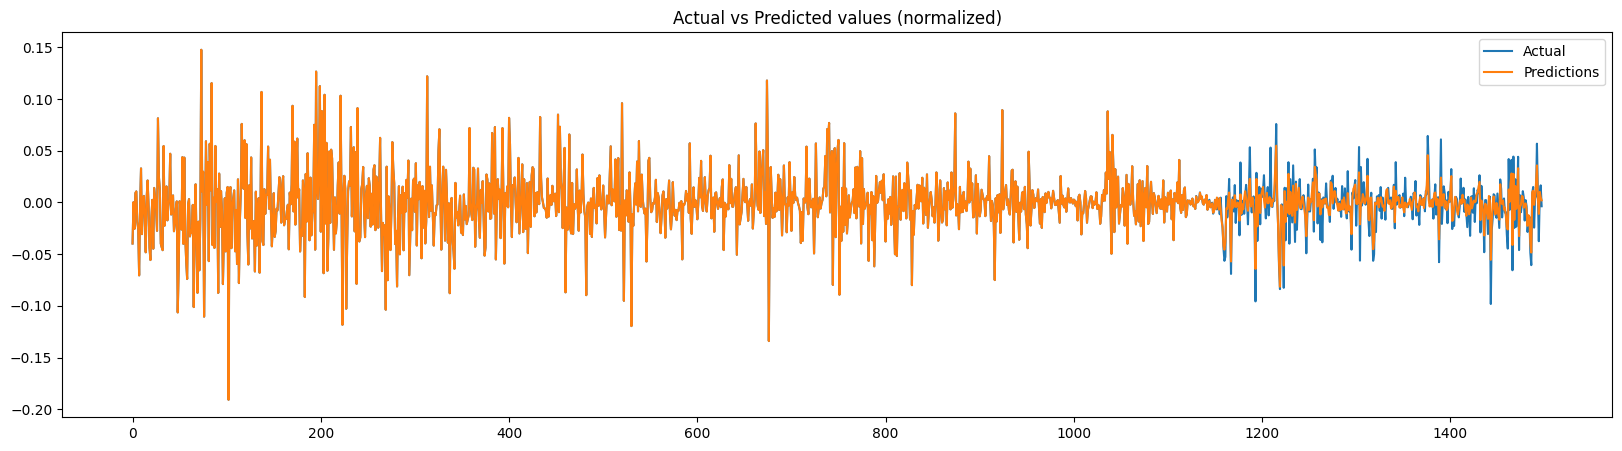

In [52]:
plt.figure(figsize=(20, 5))
plt.plot(actual_array[::-1], label='Actual')
plt.plot(prediction_array[::-1], label='Predictions')
plt.title('Actual vs Predicted values (normalized)')
plt.legend()
plt.show()

# XGBoost

In [57]:
xgb_model = xgb.XGBRegressor(random_state=0, n_jobs=-1)

xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae}, R2: {r2}')

MAE: 0.008303047130745644, R2: 0.7263987357494617
